# Project: Analyse @welovedogs tweets

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Datasets 
- An archive of @dog_rates tweets was provided by Udacity, it contains some information on the tweets eg tweet_id, text, name, ratings etc.
- A dataset containing the images included in the tweets, and thier image recognition result was also provided


> The following are questions to be explored using this dataset:
><li>Most popular dog name
><li>Most popular dog stage    
><li>Most common dog breeds
><li>Average tweet engagement and Average rating and if they are infleunced by time 
><li>Account growth rate
><li>Dog breeds with the highest rating
><li>Words used to describe the most popular 5 breeds of dogs
><li>Most popular rating numerator
><li>

<a id='wrangling'></a>

## Data wrangling
<ul>
<li><a href="#gathering">Gathering Data</a></li>
<li><a href="#assess">Assessing Data</a></li>
<li><a href="#cleaning">Cleaning Data</a></li>
</ul>

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import json
import tweepy
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import requests
from io import BytesIO
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
sns.set_style(style='darkgrid')

<a id='gathering'></a>
### Gathering Data

In [2]:
tweets = pd.read_csv('twitter-archive-enhanced.csv')
image_predictions = pd.read_csv('image-predictions.tsv',sep = '\t')

Getting Twitter API's access_token and access_secret <br>
The consumer_key and secret are hidden to comply with Twitter's API terms and conditions

In [3]:
consumer_key = 'sVYfTGyNUkedyDsCdhWc54et9'
consumer_secret = 'khGtdnpBZV0WklSWfbFOOWbROhIiMYDso0WVaX5Z79WuXdXuWX'

auth = tweepy.OAuthHandler(consumer_key,consumer_secret)

access_token = auth.access_token
access_secret = auth.access_token_secret

auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

Obtaining the `tweet_ids` to use with the twitter api

In [4]:
id = tweets.tweet_id.values

Query Twitter API for each tweet in the Twitter archive and save JSON in a text file

In [337]:
fails = []
count = 1
with open('tweet-json.txt', 'w') as writefile:
    for x in id:
        print(str(count)+ ': ' + str(x))
        count += 1
        try:
            tweet = api.get_status(x, tweet_mode = 'extended')
            print('success')
            json.dump(tweet._json, writefile)
            writefile.write('\n')
        except tweepy.TweepError as error:
            print('fail')
            fails.append(str(x) + ': ' + str(error))
            pass
            

1: 892420643555336193


KeyboardInterrupt: 

Reading from the json text file created above 

In [5]:
tweet_info = pd.DataFrame()
i_d = []
favorite_count = []
retweet_count = []
followers = []
with open('tweet-json.txt', 'r') as json_data:
    for x in json_data:
        data = json.loads(x)
        i_d.append(data.get('id'))
        favorite_count.append(data.get('favorite_count'))
        retweet_count.append(data.get('retweet_count'))
        followers.append(data.get('user').get('followers_count'))

Writing the data into a dataframe called `tweet_info`

In [6]:
tweet_info['tweet_id'] = i_d
tweet_info['favorite_count'] = favorite_count
tweet_info['retweet_count'] = retweet_count
tweet_info['followers_count'] = followers

In [7]:
tweet_info

,tweet_id,favorite_count,retweet_count,followers_count
0,892420643555336193,34952,7334,8990741
1,892177421306343426,30266,5473,8990741
2,891815181378084864,22776,3620,8990741
3,891689557279858688,38227,7524,8990741
4,891327558926688256,36493,8095,8990741
...,...,...,...,...
2326,666049248165822465,93,38,8990852
2327,666044226329800704,259,122,8990852
2328,666033412701032449,106,39,8990852
2329,666029285002620928,117,41,8990852


<a id='assess'></a>

### Assessing Data


In [8]:
tweets.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2143,669970042633789440,NaN,NaN,2015-11-26 20:04:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Julio. He was one of the original Ring...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669970042...,10,10,Julio,None,None,None,None
1308,707297311098011648,NaN,NaN,2016-03-08 20:09:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She can go from sweet to scary...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707297311...,10,10,Cassie,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
52,882045870035918850,NaN,NaN,2017-07-04 01:18:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Koko. Her owner, inspired by Barney, r...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/882045870...,13,10,Koko,None,None,None,None
910,757611664640446465,NaN,NaN,2016-07-25 16:21:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He tries to come across as fei...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/757611664...,12,10,Cooper,None,None,None,None


In [9]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
tweets.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
tweets.groupby('name').count()['tweet_id']

name
Abby            2
Ace             1
Acro            1
Adele           1
Aiden           1
               ..
such            1
the             8
this            1
unacceptable    1
very            5
Name: tweet_id, Length: 957, dtype: int64

In [12]:
image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [13]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [14]:
tweet_info.describe()

,tweet_id,favorite_count,retweet_count,followers_count
count,2.331000e+03,2331.000000,2331.000000,2.331000e+03
mean,7.419079e+17,7297.767482,2582.489918,8.990793e+06
std,6.823170e+16,11337.264701,4368.222352,5.050960e+01
min,6.660209e+17,0.000000,1.000000,8.990741e+06
25%,6.782670e+17,1262.000000,524.000000,8.990760e+06
50%,7.182469e+17,3161.000000,1205.000000,8.990789e+06
75%,7.986692e+17,8925.000000,2988.000000,8.990815e+06
max,8.924206e+17,150210.000000,74112.000000,8.991215e+06


In [15]:
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   tweet_id         2331 non-null   int64
 1   favorite_count   2331 non-null   int64
 2   retweet_count    2331 non-null   int64
 3   followers_count  2331 non-null   int64
dtypes: int64(4)
memory usage: 73.0 KB


#### Quality
##### `tweets` table
- Missing dog names in the `name` column
- Retweeted tweets and replies in table
- `Timestamp` column is an object not a datetime 
- Presence of other animals other than dogs 
- wrong `name` (officially, by, the, infuriating, a, quite, not, one, my, actually, all, his, an, mad)
- Some rating denominator values are'nt 10.
- Wrong rating values for `Bretagne`,`Bluebert`,`Darrel`,`Sam`and some others.
- Mistakes in the `rating_numerator` column.
- Missing `dog_stages` info.

##### `image_predictions` table
- No dogs predictions in some of the rows
- Underscore present in the prediction values.


##### `tweet_info` table
- Retweeted tweets and replies in table
- Missing data

##### `master_df` table
- Incorrect data types

#### Tidiness
- One variables in four columns in `tweets` table (pupper, puppo, doggo, and floofer) are all dog_stages
- Multiple columns for dog_breed prediction
- Multiple dataframes when 1 can contain all the data

<a id='cleaning'></a>

### Cleaning Data

Creating new dataframes where the cleaning operations will be performed

In [16]:
tweets_clean = tweets.copy()
image_predictions_clean = image_predictions.copy()
tweet_info_clean = tweet_info.copy()

#### Tidiness
`tweets` table
- One variables in four columns in `tweets` table (pupper, puppo, doggo, and floofer) are all dog_stages<br>

**Define** <br>
Create a function to merge the four columns into 1 and delete them.

**Code**

In [17]:
def dog_stage (a,b,c,d):
    if a == 'doggo':
        return (a)
    elif b == 'floofer':
        return (b)
    elif c == 'pupper':
        return (c)
    elif d == 'puppo':
        return (d)
    else:
        return(np.nan)

In [18]:
dog_stages = map(dog_stage,tweets_clean['doggo'],tweets_clean['floofer'],tweets_clean['pupper'],tweets_clean['puppo'])

In [19]:
tweets_clean['dog_stages'] = list(dog_stages)

In [20]:
tweets_clean = tweets_clean.drop(columns=['doggo','floofer','pupper','puppo'])

**Test**

In [21]:
tweets_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,NaN
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


#### Quality
`tweets` table
- Retweeted tweets and replies in table<br>

**Define** <br>
Remove the retweets and replies from the dataframe.

**Code**

In [22]:
tweets_clean = tweets_clean.query('in_reply_to_status_id != in_reply_to_status_id and retweeted_status_id != retweeted_status_id')

In [23]:
tweets_clean.drop(columns=['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], inplace= True)

**Test**

In [24]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   dog_stages          336 non-null    object
dtypes: int64(3), object(6)
memory usage: 163.8+ KB


#### Quality
`tweets` table
- Timestamp column is an object not a datetime<br>

**Define** <br>
Change timestamp datatype to datetime using pandas `to_datetime` function.

**Code**

In [25]:
tweets_clean['timestamp'] = pd.to_datetime(tweets_clean.timestamp)

**Test**

In [26]:
tweets_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN
...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,None,NaN
2352,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,a,NaN
2353,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,a,NaN
2354,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,a,NaN


#### Quality
`tweets` table
- Missing dog names in the name column
- Wrong name (officially, by, the, infuriating, a, quite, not, one, my, actually, all, his, an, mad)<br>

**Define** <br>
Create function to get all dog names after string `name is` and `named` in the text column.<br>
Prevent words such as `a`,`an`,`by`,`not`,`my` etc from being in the name column.<br>
All words('a','an','by','not','my','life','old','just','very', 'this','light','getting','unacceptable','space','None','officially','the','infuriating','such','quite', 'one', 'actually', 'all', 'his','incredibly','mad')


**Code**

In [27]:
def get (data):
    indexes =[]
    names =[]
    for index,df in data.iterrows():
        name = re.findall(r'(?<=\bThis is\s)([A-Z]\w+)| (?<=\bname is\s)([A-Z]\w+)|(?<=\bnamed\s)([A-Z]\w+)|(?<=\bMeet\s)([A-Z]\w+)|(?<=\bHere is\s)([A-Z]\w+)|(?<=\bhello to\s)([A-Z]\w+)|(?<=\bthis is\s)([A-Z]\w+)' ,df['text']) 
        for x in name:
            indexes.append(index)
            strin = re.findall(r'(\w+)', str(x))
            names.append(strin[0])
    return indexes,names

In [28]:
index, names = get(tweets_clean)
new_name = pd.DataFrame(index = index, data=names ,columns=['name'])
new_name

,name
0,Phineas
1,Tilly
2,Archie
3,Darla
4,Franklin
...,...
2315,Christoper
2317,Jimothy
2318,Kreggory
2319,Scout


In [29]:
tweets_clean.drop(columns=['name'],inplace=True)
tweets_clean = tweets_clean.merge(new_name,left_index=True,right_index=True,how = 'left')

In [30]:
tweets_clean.drop_duplicates(subset =['tweet_id'],inplace=True)

**Test**

In [31]:
tweets_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,name
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,NaN,Phineas
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,Tilly
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,Archie
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,NaN,Darla
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,Franklin
...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN
2352,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,NaN,NaN
2353,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,NaN,NaN
2354,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,NaN,NaN


#### Quality
`tweets` table
- Presence of other animals other than dogs<br>

**Define** 
Get all rows that do not contain dogs and drop them<br>


**Code**

In [32]:
non_dogs = (tweets_clean[(tweets_clean['text'].str.contains('We only rate dogs')) | 
                         (tweets_clean['text'].str.contains('Please only send dogs')) | 
                         (tweets_clean['text'].str.contains('please only send dogs')) | 
                         (tweets_clean['text'].str.contains('we only rate dogs')) | 
                         (tweets_clean['text'].str.contains('2 legs')) |
                         (tweets_clean['text'].str.contains('please only send in dogs')) |
                         (tweets_clean['text'].str.contains('Please only send in dogs'))])

In [33]:
tweets_clean.drop(non_dogs.index,inplace=True)

**Test**

In [34]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2034 non-null   int64              
 1   timestamp           2034 non-null   datetime64[ns, UTC]
 2   source              2034 non-null   object             
 3   text                2034 non-null   object             
 4   expanded_urls       2031 non-null   object             
 5   rating_numerator    2034 non-null   int64              
 6   rating_denominator  2034 non-null   int64              
 7   dog_stages          336 non-null    object             
 8   name                1420 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 158.9+ KB


#### Quality
`tweets` table
- Some rating denominator values are'nt 10
- Wrong rating values for `Bretagne`,`Bluebert`,`Darrel`,`sam`and some others
- Mistakes in the `rating_numerator` column.<br>

**Define**<br>
Change the mistakes made in some of the column manually.<br>
Create a function to correct the other mistakes <br>


**Code**

In [35]:
tweets_clean[(tweets_clean['rating_denominator'] != 10) | (tweets_clean['rating_numerator'] >= 16)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,name
433,820690176645140481,2017-01-15 17:52:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,NaN,NaN
516,810984652412424192,2016-12-19 23:06:23+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",24,7,NaN,Sam
695,786709082849828864,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,75,10,NaN,Logan
763,778027034220126208,2016-09-20 00:24:34+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,27,10,pupper,Sophie
902,758467244762497024,2016-07-28 01:00:57+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,NaN,NaN
979,749981277374128128,2016-07-04 15:00:45+00:00,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,10,NaN,Atticus
1068,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",https://twitter.com/dog_rates/status/740373189...,9,11,NaN,Bretagne
1120,731156023742988288,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,NaN,NaN
1165,722974582966214656,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,https://twitter.com/dog_rates/status/722974582...,4,20,NaN,NaN
1202,716439118184652801,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,https://twitter.com/dog_rates/status/716439118...,50,50,NaN,Bluebert


In [36]:
#Darrel is rated 10/10
tweets_clean.loc[1662,['rating_numerator','rating_denominator']] = 10,10

In [37]:
# Bluebert is rated 11/10
tweets_clean.loc[1202,['rating_numerator','rating_denominator']] = 11,10

In [38]:
#Bretagne is rated 14/10
tweets_clean.loc[1068,['rating_numerator','rating_denominator']] = 14,10 

In [39]:
# `666287406224695296` is rated 9/10
tweets_clean.loc[2335,['rating_numerator','rating_denominator']] = 9,10 

In [40]:
# Logan is rated 9.75/10 approximately 10/10
tweets_clean.loc[695,['rating_numerator','rating_denominator']] = 10,10 

In [41]:
# sophie is rated 11.27/10 approximately 11/10
tweets_clean.loc[763,['rating_numerator','rating_denominator']] = 11,10 

In [42]:
# `680494726643068929` is rated 11.26/10  approximately 11/10
tweets_clean.loc[1712,['rating_numerator','rating_denominator']] = 11,10 

In [43]:
# `722974582966214656` is rated 13/10
tweets_clean.loc[1165,['rating_numerator','rating_denominator']] = 13,10 

In [44]:
# sam has no rating drop sam 
tweets_clean.drop(516,inplace=True)

In [45]:
 tweets_clean[(tweets_clean['rating_denominator'] != 10)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,name
433,820690176645140481,2017-01-15 17:52:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,https://twitter.com/dog_rates/status/820690176...,84,70,NaN,NaN
902,758467244762497024,2016-07-28 01:00:57+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,https://twitter.com/dog_rates/status/758467244...,165,150,NaN,NaN
1120,731156023742988288,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,https://twitter.com/dog_rates/status/731156023...,204,170,NaN,NaN
1228,713900603437621249,2016-03-27 01:29:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,https://twitter.com/dog_rates/status/713900603...,99,90,NaN,NaN
1254,710658690886586372,2016-03-18 02:46:49+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,https://twitter.com/dog_rates/status/710658690...,80,80,NaN,NaN
1274,709198395643068416,2016-03-14 02:04:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",https://twitter.com/dog_rates/status/709198395...,45,50,NaN,NaN
1351,704054845121142784,2016-02-28 21:25:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,https://twitter.com/dog_rates/status/704054845...,60,50,NaN,NaN
1433,697463031882764288,2016-02-10 16:51:59+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,https://twitter.com/dog_rates/status/697463031...,44,40,NaN,NaN
1635,684222868335505415,2016-01-05 04:00:18+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Someone help the girl is being mugged. Several...,https://twitter.com/dog_rates/status/684222868...,121,110,NaN,NaN
1779,677716515794329600,2015-12-18 05:06:23+00:00,"<a href=""http://twitter.com/download/iphone"" r...",IT'S PUPPERGEDDON. Total of 144/120 ...I think...,https://twitter.com/dog_rates/status/677716515...,144,120,NaN,NaN


In [46]:
def ratings_numerator (data):
    new_numer = []
    for index,df in data.iterrows():
        if df.rating_denominator > 10 :
            div = int(str(df.rating_denominator)[:-1])
            new= df.rating_numerator/div
            new_numer.append(new)
        else:
            new_numer.append(df.rating_numerator)
    return new_numer       

In [47]:
tweets_clean['rating_numerator'] = ratings_numerator(tweets_clean)

In [48]:
tweets_clean['rating_denominator'] = tweets_clean['rating_denominator'].apply(lambda x: x/int(str(x)[:-1]) if x >10 else x)

**Test**

In [49]:
tweets_clean[(tweets_clean['rating_denominator'] != 10) | (tweets_clean['rating_numerator'] >= 16)]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,name
979,749981277374128128,2016-07-04 15:00:45+00:00,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776.0,10.0,NaN,Atticus
2074,670842764863651840,2015-11-29 05:52:33+00:00,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420.0,10.0,NaN,NaN


Reseting index

In [50]:
tweets_clean.reset_index(drop = True,inplace=True)

#### Quality
`tweets` table
- Missing `dog_stages` info.

**Define**<br>
Some dog stages were not extracted because the occured in plural form. Extract those stages and add them to the `dog_stages` column<br>


**Code**

In [51]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033 entries, 0 to 2032
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2033 non-null   int64              
 1   timestamp           2033 non-null   datetime64[ns, UTC]
 2   source              2033 non-null   object             
 3   text                2033 non-null   object             
 4   expanded_urls       2030 non-null   object             
 5   rating_numerator    2033 non-null   float64            
 6   rating_denominator  2033 non-null   float64            
 7   dog_stages          336 non-null    object             
 8   name                1419 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(5)
memory usage: 143.1+ KB


In [52]:
for i,y in tweets_clean.iterrows():
    if 'doggos' in y['text']:
        tweets_clean.at[i,'dog_stages'] = 'doggo'
    elif 'puppers' in y['text']:
        tweets_clean.at[i,'dog_stages'] = 'pupper'
    elif 'puppos' in y['text']:
        tweets_clean.at[i,'dog_stages'] = 'puppo'

In [53]:
 tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033 entries, 0 to 2032
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2033 non-null   int64              
 1   timestamp           2033 non-null   datetime64[ns, UTC]
 2   source              2033 non-null   object             
 3   text                2033 non-null   object             
 4   expanded_urls       2030 non-null   object             
 5   rating_numerator    2033 non-null   float64            
 6   rating_denominator  2033 non-null   float64            
 7   dog_stages          367 non-null    object             
 8   name                1419 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(5)
memory usage: 143.1+ KB


#### Quality
`image_predictions` table
- No dogs predictions in some of the rows


#### Tidyness
`image_predictions` table
- Only one column needed for dog_breed prediction
<br>

**Define**<br>
Write a function to get the first correct dog prediction and use that prediction as the breed of the dog. <br>
Drop null values.<br>
Drop p1,p2,p3,their respective confidence and dog columns


**Code**

In [54]:
def breed (dataframe):
    breed = []
    for index,df in dataframe.iterrows():
        if df.p1_dog == True:
            breed.append(df.p1)
        elif df.p2_dog == True:
            breed.append(df.p2)
        elif df.p3_dog == True:
            breed.append(df.p3)
        else:
            breed.append(np.nan)
    return breed

In [55]:
image_predictions_clean['dog_breed'] = breed(image_predictions_clean)

In [56]:
image_predictions_clean.dropna(subset=['dog_breed'],inplace=True)

In [57]:
image_predictions_clean.drop(columns=['p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],inplace=True)

**Test**

In [58]:
image_predictions_clean

,tweet_id,jpg_url,img_num,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher
...,...,...,...,...
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador_retriever
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua


#### Quality
`image_predictions` table
- Underscore present in the prediction values.

**Define**<br>
Use `str.title()` and `str.replace` to remove the underscore and the capitalize each word <br>



**Code**


In [59]:
image_predictions_clean['dog_breed']= image_predictions_clean['dog_breed'].str.title().str.replace('_',' ')

**Test**

In [60]:
image_predictions_clean

,tweet_id,jpg_url,img_num,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher
...,...,...,...,...
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake Bay Retriever
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,Basset
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,Labrador Retriever
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua


#### Quality
`tweet_info` table
- Retweeted tweets and replies in table
- Missing data<br>

#### Tidyness
- Multiple dataframes when 1 can contain all the data
<br>

**Define**<br>
Merge all tables together on the `tweet_id` column<br>


**Code**

 

In [61]:
master_df = tweets_clean.merge(tweet_info_clean,on='tweet_id').merge(image_predictions_clean[['tweet_id','dog_breed','jpg_url']],on='tweet_id')

**Test**

In [62]:
master_df

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,name,favorite_count,retweet_count,followers_count,dog_breed,jpg_url
0,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,NaN,Tilly,30266,5473,8990741,Chihuahua,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
1,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,NaN,Archie,22776,3620,8990741,Chihuahua,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
2,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,NaN,Darla,38227,7524,8990741,Labrador Retriever,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
3,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,NaN,Franklin,36493,8095,8990741,Basset,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
4,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,NaN,NaN,18415,2713,8990741,Chesapeake Bay Retriever,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10.0,NaN,NaN,93,38,8990852,Miniature Pinscher,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
1602,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10.0,NaN,NaN,259,122,8990852,Rhodesian Ridgeback,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
1603,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10.0,NaN,NaN,106,39,8990852,German Shepherd,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
1604,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10.0,NaN,NaN,117,41,8990852,Redbone,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg


#### Quality
`master_df` table
- Incorrect data types<br>

**Define**<br>
Use the `as_type` function to assign the correct data types to columns<br>
- `rating_denominator` and `rating_numerator` as integers<br>
- `dog_stages` as category<br>


**Code**

In [99]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 0 to 1605
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1606 non-null   int64              
 1   timestamp           1606 non-null   datetime64[ns, UTC]
 2   source              1606 non-null   object             
 3   text                1606 non-null   object             
 4   expanded_urls       1606 non-null   object             
 5   rating_numerator    1606 non-null   float64            
 6   rating_denominator  1606 non-null   float64            
 7   dog_stages          275 non-null    object             
 8   name                1204 non-null   object             
 9   favorite_count      1606 non-null   int64              
 10  retweet_count       1606 non-null   int64              
 11  followers_count     1606 non-null   int64              
 12  dog_breed           1606 non-null 

In [100]:
master_df[['rating_denominator','rating_numerator']] = master_df[['rating_denominator','rating_numerator']].astype('int')

In [102]:
master_df['dog_stages'] = master_df['dog_stages'].astype('category')

**Test**

In [103]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1606 entries, 0 to 1605
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1606 non-null   int64              
 1   timestamp           1606 non-null   datetime64[ns, UTC]
 2   source              1606 non-null   object             
 3   text                1606 non-null   object             
 4   expanded_urls       1606 non-null   object             
 5   rating_numerator    1606 non-null   int32              
 6   rating_denominator  1606 non-null   int32              
 7   dog_stages          275 non-null    category           
 8   name                1204 non-null   object             
 9   favorite_count      1606 non-null   int64              
 10  retweet_count       1606 non-null   int64              
 11  followers_count     1606 non-null   int64              
 12  dog_breed           1606 non-null 

<a id='eda'></a>

## Exploratory Data Analysis

### Research Question 1: Most popular and least popular dog names.

In [105]:
master_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,name,favorite_count,retweet_count,followers_count,dog_breed,jpg_url
0,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,Tilly,30266,5473,8990741,Chihuahua,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
1,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,Archie,22776,3620,8990741,Chihuahua,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
2,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,NaN,Darla,38227,7524,8990741,Labrador Retriever,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
3,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,Franklin,36493,8095,8990741,Basset,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
4,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,18415,2713,8990741,Chesapeake Bay Retriever,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg


- Grouping the dataframe by the names of the dogs and counting the number of occurences of each name
- Sorting the values so that the most popular appears on top and the least popular at the bottom. 

In [106]:
dog_names = master_df.groupby(['name']).count()['tweet_id']

In [107]:
dog_names= dog_names.sort_values(ascending =False)
dog_names

name
Cooper     10
Oliver      9
Tucker      9
Lucy        9
Charlie     9
           ..
Gromit      1
Gunner      1
Guss        1
Gustaf      1
Zooey       1
Name: tweet_id, Length: 850, dtype: int64

Getting random colours to use in the graph

In [108]:
all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k =10)

Plotting a bar chart to show results

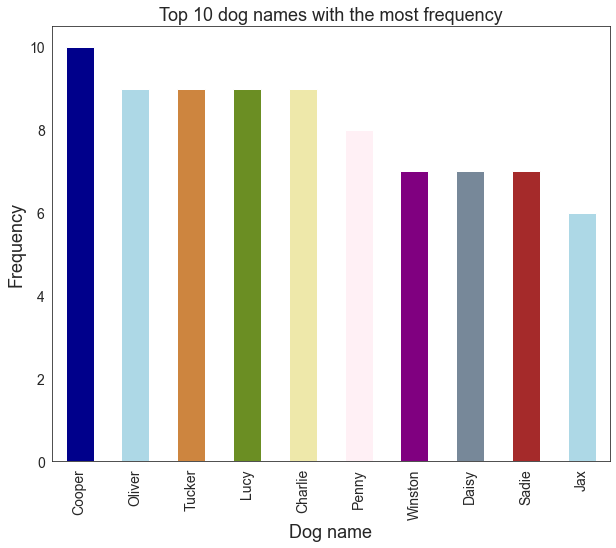

In [109]:
dog_names.iloc[:10].plot.bar(figsize = (10,8),color=c)
plt.xlabel('Dog name', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.title('Top 10 dog names with the most frequency', fontsize = 18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);

Dog names that occur only once

In [110]:
dog_names[dog_names == 1]

name
Pippin    1
Opie      1
Ozzy      1
Ozzie     1
Luther    1
         ..
Gromit    1
Gunner    1
Guss      1
Gustaf    1
Zooey     1
Name: tweet_id, Length: 666, dtype: int64

Average retweet count,favorite count and ratings for the top ten rated dogs

In [111]:
master_df.groupby(['name']).mean().loc[dog_names.iloc[:10].index] 

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,followers_count
name,,,,,,
Cooper,7.588834e+17,11.300000,10.0,6101.700000,1570.700000,8.990777e+06
Oliver,7.468092e+17,11.333333,10.0,6044.333333,1576.444444,8.990783e+06
Tucker,7.701575e+17,12.000000,10.0,7605.888889,1821.444444,8.990775e+06
Lucy,7.391712e+17,11.222222,10.0,8581.777778,2758.777778,8.990784e+06
Charlie,7.623754e+17,11.666667,10.0,8950.000000,2212.333333,8.990776e+06
Penny,7.635415e+17,11.000000,10.0,10924.875000,3177.250000,8.990780e+06
Winston,7.618126e+17,10.571429,10.0,8863.428571,2263.285714,8.990779e+06
Daisy,7.618166e+17,11.857143,10.0,8476.428571,2072.571429,8.990781e+06
Sadie,7.151968e+17,10.285714,10.0,5312.000000,1325.142857,8.990794e+06


### Research Question 2: Most popular dog stage

Get all dog stages that aren't equal to nan and count the number of times they appear in the data<br>

In [112]:
stages_plot = master_df[master_df['dog_stages'] == master_df['dog_stages']].groupby(['dog_stages']).count()['tweet_id']

In [113]:
stages_plot.index = stages_plot.index.str.title()
stages_plot

dog_stages
Doggo       66
Floofer      7
Pupper     181
Puppo       21
Name: tweet_id, dtype: int64

Plotting a pie chart to show the composition of the `dog_stages` column

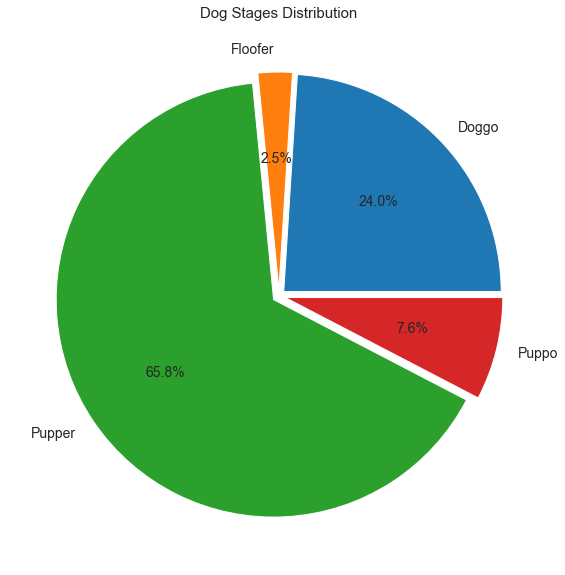

In [114]:
pie, ax = plt.subplots(figsize= [10,10])
labels = stages_plot.keys()
plt.pie(x=stages_plot, autopct="%.1f%%", explode=[0.03]*4, labels=labels, pctdistance=0.6,textprops={'fontsize':14})
plt.title("Dog Stages Distribution", fontsize=15);

Average retweet count,favorite count and ratings for dog stages

In [115]:
 master_df[master_df['dog_stages'] == master_df['dog_stages']].groupby(['dog_stages']).mean()

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,followers_count
dog_stages,,,,,,
doggo,7.986528e+17,11.772727,10.0,17620.348485,5871.757576,8.990763e+06
floofer,7.665514e+17,12.000000,10.0,11619.714286,4153.142857,8.990776e+06
pupper,7.192243e+17,10.845304,10.0,6447.513812,1962.861878,8.990797e+06
puppo,8.103328e+17,11.952381,10.0,20200.857143,5491.142857,8.990760e+06


### Research Question 3: Most common dog breeds.

Counting how many times each breed of dog appears in our data

In [116]:
common_breeds = master_df.groupby(['dog_breed']).count()['tweet_id'].sort_values(ascending=False)

In [117]:
common_breeds.head(10)

dog_breed
Golden Retriever      152
Labrador Retriever     98
Pembroke               91
Chihuahua              89
Pug                    59
Toy Poodle             49
Chow                   45
Pomeranian             41
Samoyed                38
Malamute               32
Name: tweet_id, dtype: int64

Plotting a Dot plot to show results of the first 10 dogs

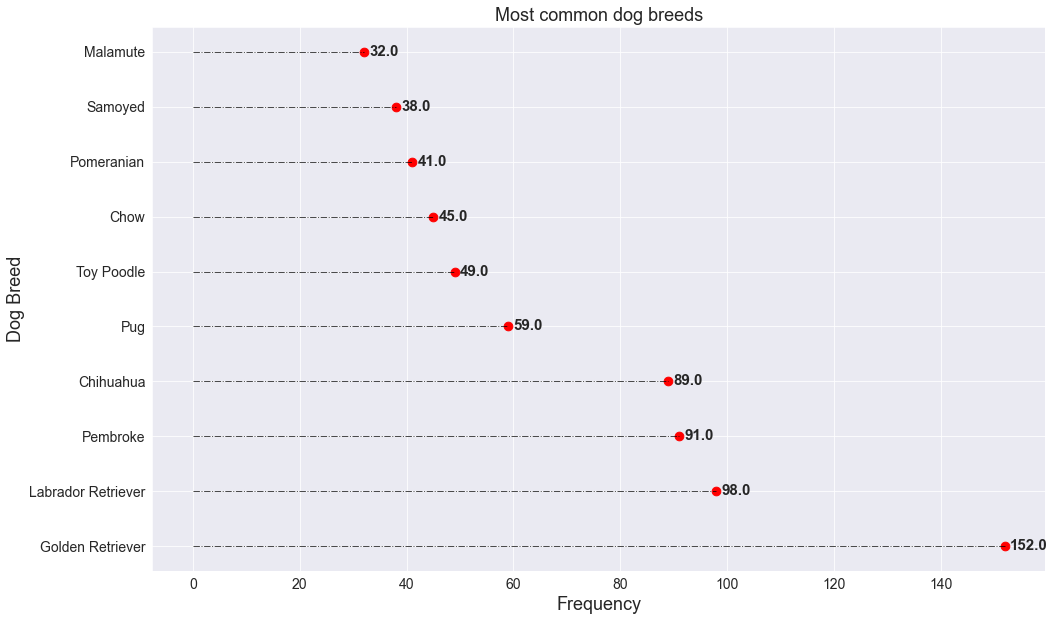

In [118]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(16,10))
ax.hlines(y=common_breeds[:10].index, xmin=0, xmax=[common_breeds[:10]], color='black', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=common_breeds[:10].index, x=common_breeds[:10], s=75, color='red')
plt.title('Most common dog breeds',fontsize= 18)
plt.xlabel('Frequency', fontsize = 18)
plt.ylabel('Dog Breed', fontsize = 18)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14);
for i, val in enumerate(common_breeds[:10].values):
    plt.text(val+1, i, float(val), horizontalalignment='left', verticalalignment='center', fontdict={'fontweight':600, 'size':15})

Average retweet count,favorite count and ratings for dog breeds

In [119]:
 master_df.groupby(['dog_breed']).mean().loc[common_breeds[:10].index]

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,followers_count
dog_breed,,,,,,
Golden Retriever,7.562204e+17,11.552632,10.0,11059.217105,3188.000000,8.990782e+06
Labrador Retriever,7.475461e+17,11.224490,10.0,10079.479592,3016.571429,8.990786e+06
Pembroke,7.545754e+17,11.428571,10.0,9964.219780,2642.373626,8.990783e+06
Chihuahua,7.193979e+17,10.516854,10.0,7446.325843,2388.000000,8.990804e+06
Pug,7.192311e+17,10.288136,10.0,5591.101695,1637.576271,8.990799e+06
Toy Poodle,7.204677e+17,10.979592,10.0,5806.224490,1902.755102,8.990805e+06
Chow,7.413433e+17,11.377778,10.0,6761.800000,1898.844444,8.990788e+06
Pomeranian,7.183631e+17,10.951220,10.0,6944.170732,2329.585366,8.990798e+06
Samoyed,7.445126e+17,11.710526,10.0,10709.736842,3706.473684,8.990785e+06


### Research Question 4: Average tweet engagement and Average rating and if they are infleunced by time.


In [120]:
master_df

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_stages,name,favorite_count,retweet_count,followers_count,dog_breed,jpg_url
0,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,NaN,Tilly,30266,5473,8990741,Chihuahua,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
1,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,NaN,Archie,22776,3620,8990741,Chihuahua,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
2,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,NaN,Darla,38227,7524,8990741,Labrador Retriever,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
3,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,NaN,Franklin,36493,8095,8990741,Basset,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
4,891087950875897856,2017-07-29 00:08:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,18415,2713,8990741,Chesapeake Bay Retriever,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,NaN,93,38,8990852,Miniature Pinscher,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg
1602,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,NaN,NaN,259,122,8990852,Rhodesian Ridgeback,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg
1603,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,NaN,NaN,106,39,8990852,German Shepherd,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg
1604,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,NaN,NaN,117,41,8990852,Redbone,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg


Divide the data into months so that a row contains the average data for a month

In [121]:
months = master_df.groupby(pd.Grouper(key='timestamp', freq='M')).mean().reset_index()

In [122]:
months

,timestamp,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,followers_count
0,2015-11-30 00:00:00+00:00,6.686216e+17,9.444444,10.0,1031.653333,400.644444,8.990848e+06
1,2015-12-31 00:00:00+00:00,6.760381e+17,10.080292,10.0,3327.474453,1340.722628,8.990821e+06
2,2016-01-31 00:00:00+00:00,6.879587e+17,10.402985,10.0,3430.753731,1215.925373,8.990813e+06
3,2016-02-29 00:00:00+00:00,6.992185e+17,10.461538,10.0,3272.307692,1104.307692,8.990801e+06
4,2016-03-31 00:00:00+00:00,7.092907e+17,10.617647,10.0,3842.343137,1259.803922,8.990791e+06
5,2016-04-30 00:00:00+00:00,7.203873e+17,10.574468,10.0,4237.042553,1368.468085,8.990796e+06
6,2016-05-31 00:00:00+00:00,7.314065e+17,11.088889,10.0,5542.288889,1813.333333,8.990788e+06
7,2016-06-30 00:00:00+00:00,7.434617e+17,10.338710,10.0,10052.209677,3960.467742,8.990785e+06
8,2016-07-31 00:00:00+00:00,7.536898e+17,10.831169,10.0,6317.753247,2125.142857,8.990779e+06
9,2016-08-31 00:00:00+00:00,7.656858e+17,11.173913,10.0,8335.065217,2521.760870,8.990772e+06


Plotting a multiple Time series plot to show the change over time of retweets and favorites

<ipython-input-123-7fe29cf2c01b>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x,rotation= 60,fontdict={'fontsize':12},color='black')


Text(0.5, 1.0, 'Retweet and Favorite counts over time')

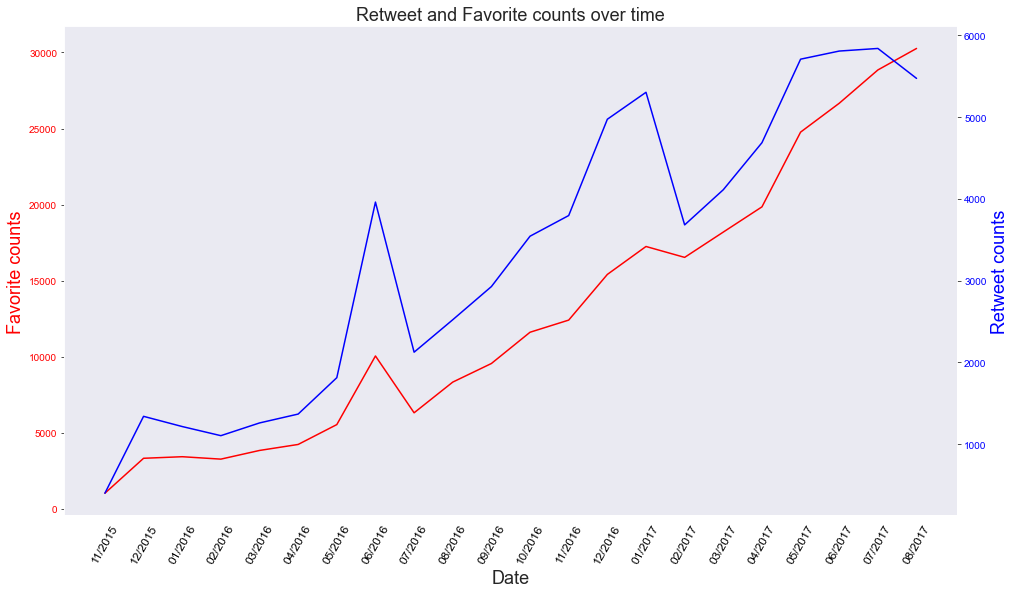

In [123]:
x = months['timestamp'].dt.strftime('%m/%Y')
y1 = months['favorite_count']
y2 = months['retweet_count']

sns.set_style(style='dark')

# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9))
ax1.plot(x, y1, color='red')

ax1.set_xlabel('Date',fontsize = 18)
ax1.set_xticklabels(x,rotation= 60,fontdict={'fontsize':12},color='black')
ax1.set_ylabel('Favorite counts',fontsize = 18,color = 'red')
ax1.tick_params(axis ='y',labelcolor = 'red')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()
ax2.plot(x, y2, color='blue')

ax2.set_ylabel('Retweet counts',fontsize = 18,color = 'blue')
ax2.tick_params(axis ='y',labelcolor = 'blue')

plt.title('Retweet and Favorite counts over time', fontsize= 18)

Plotting a time series plot for average rating

<ipython-input-124-f5bf35b277ae>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x,rotation= 60,fontdict={'fontsize':12})


Text(0.5, 1.0, 'Average ratings over time')

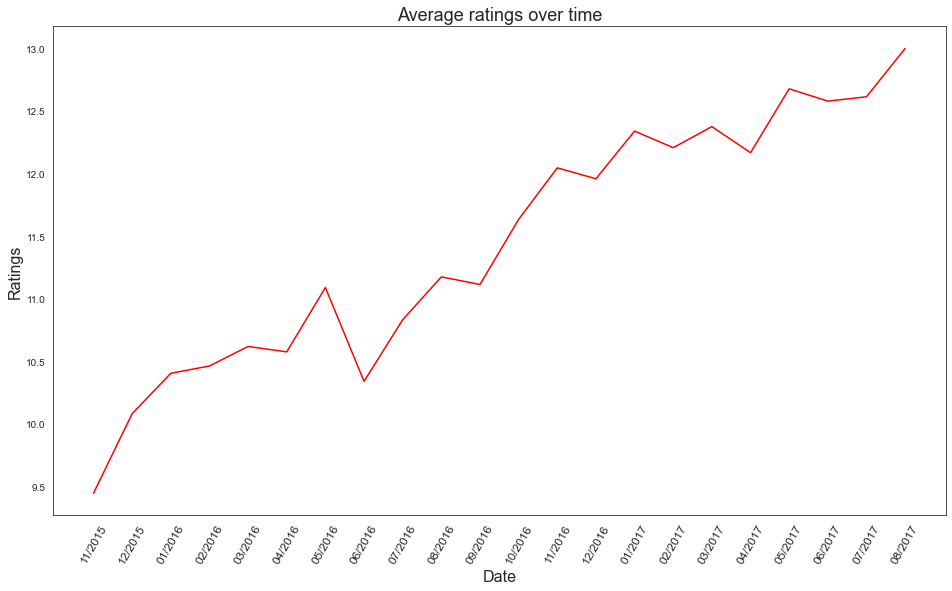

In [124]:
x = months['timestamp'].dt.strftime('%m/%Y')
y3 = months['rating_numerator']

sns.set_style(style ='white')

fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.plot(x, y3, color='red')
ax.set_xlabel('Date',fontsize= 16)
ax.set_xticklabels(x,rotation= 60,fontdict={'fontsize':12})
ax.set_ylabel('Ratings',fontsize = 16)

plt.title('Average ratings over time', fontsize= 18)

### Research Question 5: Account growth rate.


In [125]:
months[['timestamp','followers_count']]

,timestamp,followers_count
0,2015-11-30 00:00:00+00:00,8.990848e+06
1,2015-12-31 00:00:00+00:00,8.990821e+06
2,2016-01-31 00:00:00+00:00,8.990813e+06
3,2016-02-29 00:00:00+00:00,8.990801e+06
4,2016-03-31 00:00:00+00:00,8.990791e+06
5,2016-04-30 00:00:00+00:00,8.990796e+06
6,2016-05-31 00:00:00+00:00,8.990788e+06
7,2016-06-30 00:00:00+00:00,8.990785e+06
8,2016-07-31 00:00:00+00:00,8.990779e+06
9,2016-08-31 00:00:00+00:00,8.990772e+06


Percentage of followers lost/gained from 11/2015 to 08/2017

In [126]:
growth_rate = (round(months.loc[21,'followers_count']) - round(months.loc[0,'followers_count']))/round(months.loc[21,'followers_count'])

In [127]:
print('@weratedogs twitter account growth rate from november 2015 to august 2017 is {:.6f}%'.format(growth_rate))

@weratedogs twitter account growth rate from november 2015 to august 2017 is -0.000012%


Plotting a time series for the change in the numbers of followers

<ipython-input-128-428f7854d7ad>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x,rotation= 60,fontdict={'fontsize':12})


Text(0.5, 1.0, 'Account followers growth rate')

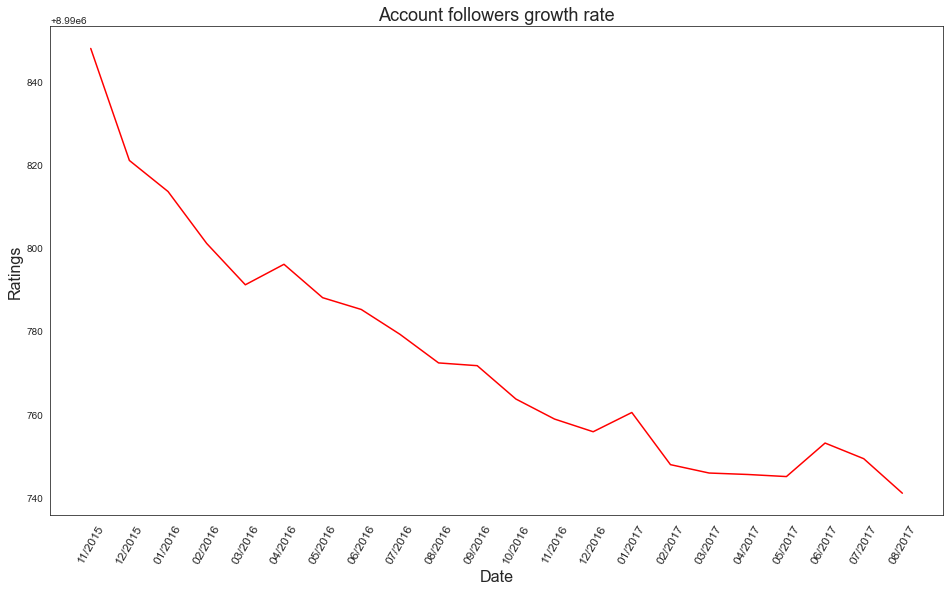

In [128]:
x = months['timestamp'].dt.strftime('%m/%Y')
y4 = months['followers_count']

sns.set_style(style ='white')

fig, ax = plt.subplots(1,1,figsize=(16,9))
ax.plot(x, y4, color='red')
ax.set_xlabel('Date',fontsize= 16)
ax.set_xticklabels(x,rotation= 60,fontdict={'fontsize':12})
ax.set_ylabel('Ratings',fontsize = 16)

plt.title('Account followers growth rate', fontsize= 18)

### Research Question 6: Words used to describe the most popular 5 breeds of dogs.

Get pictures and text associated with the most popular dog breeds

In [129]:
pic = {}
text = {}
for x in common_breeds.head().index:
    x1 = master_df[master_df['dog_breed']== x] 
    pic[x] = x1['jpg_url'].values
    text[x] = re.sub(r'(http\S+)','',x1['text'].str.cat(sep='.'))

In [130]:
print(text.get('Golden Retriever'))

This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 puppared puppo #BarkWeek  is Jim. He found a fren. Taught him how to sit like the good boys. 12/10 for both  is Zeke. He has a new stick. Very proud of it. Would like you to throw it for him without taking it. 13/10 would do my best  is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10  is Alfy. You're witnessing his first watermelon experience. I think it was a success. 13/10 happy 4th Alfy 🇺🇸  is Koko. Her owner, inspired by Barney, recently built a cart for her to use during walks if she got tired. 13/10 rest easy Koko  is Bella. She had her first beach experience this morning. Complete success. 12/10 would perform a sandy boop  is Benedict. He wants to thank you for this delightful urban walk. Hopes you know he loves you. 13/10 super duper good boy  is Zoey. She really likes the planet. Would hate to see willful ignorance and the denia

In [131]:
pic.get('Golden Retriever')[0]

'https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg'

Create new folder for the pictures of the dogs

In [132]:
folder_name = 'bog_breeds'
# Make directory if it doesn't already exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

Download the images into the above folder

In [133]:
#for x in pic.keys():
   # img = pic.get(x)[0]
   # r = requests.get(img)
   # dw_img = Image.open(BytesIO(r.content))
   # image_file_format = img.split('.')[-1]
   # dw_img.save(folder_name + "/" + x + '.' + image_file_format)
    

Creating a word cloud using the images downloaded as mask and word colour


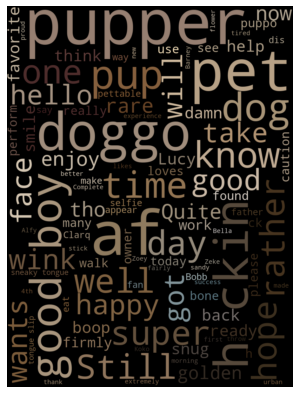

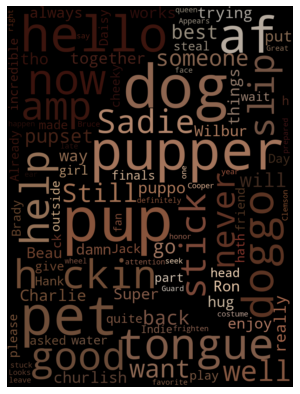

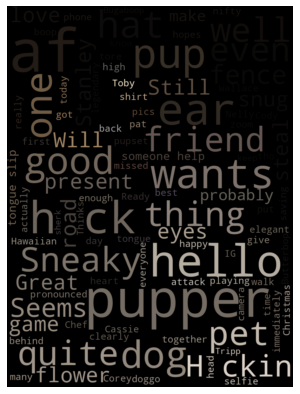

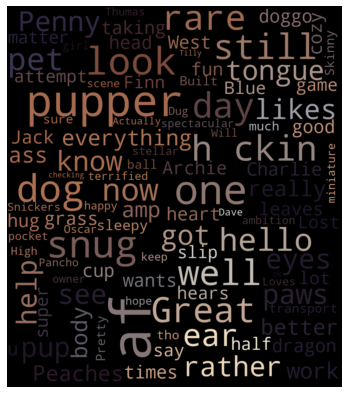

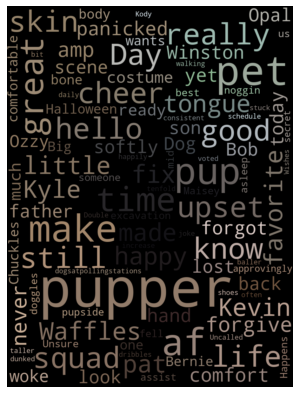

In [134]:
for breed in common_breeds.head().index:
    mask = np.array(Image.open("bog_breeds/" + breed + ".jpg"))
    wordcloud = WordCloud( mode="RGBA", max_words=100, mask=mask).generate(text.get(breed))

    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[7,7])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    #plt.savefig("bog_breeds/" + breed +"_colud" ".jpg", format="jpg")
    plt.show()

### Research Question 7: Most popular rating numerator.

In [137]:
ratings =  master_df.groupby(['rating_numerator']).count()['tweet_id']

Text(0.5, 1.0, 'Ratings Distribution')

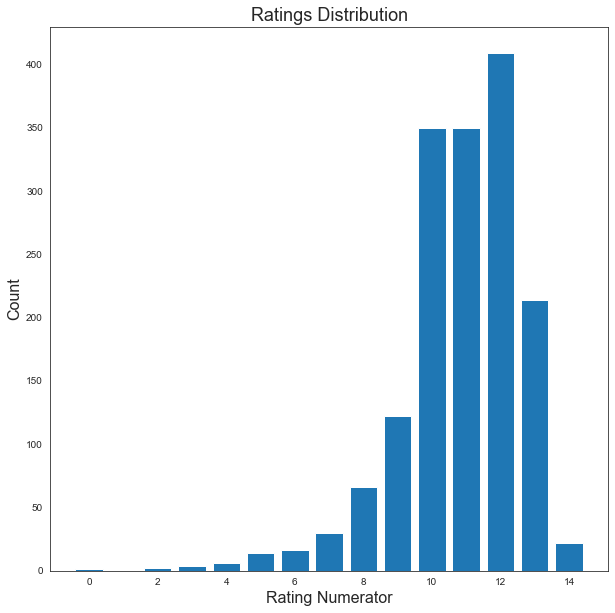

In [151]:
bar, ax = plt.subplots(figsize= [10,10])

ax.bar(x= ratings.index ,height=ratings)
ax.set_xlabel('Rating Numerator', fontsize = 16)
ax.set_ylabel('Count',fontsize = 16 )
plt.title('Ratings Distribution', fontsize= 18)

<a id='conclusions'></a>

## Conclusions